<a href="https://colab.research.google.com/github/superbunny38/2021DeepLearning/blob/main/pytorch/NeuralStyleTransfer_Demo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
from torch.utils.data import Dataset,DataLoader
import torch
from torch import nn
from torch.autograd import Variable
from torchvision.datasets import MNIST
from torchvision import datasets, transforms
from torchvision.utils import save_image
import torch.optim as optim
import numpy as np
import pandas as pd
import torch.nn.parallel
import torch.optim as optim
import torch.utils.data

In [2]:
image_size = 512
is_cuda = torch.cuda.is_available()
#필요한 모든 전처리를 수행하며 정규화를 위해 VGG 모델이 사용한 것과 동일한 값 사용
preprocessing = transforms.Compose([transforms.Resize(image_size),
                           transforms.ToTensor(),
                           transforms.Lambda(lambda x: x[torch.LongTensor([2,1,0])]), 
                           transforms.Normalize(mean=[0.40760392, 0.45795686, 0.48501961], 
                                                std=[1,1,1]),
                           transforms.Lambda(lambda x: x.mul_(255)),
                          ])
#모델의 출력을 원본 값으로 역정규화
processing = transforms.Compose([transforms.Lambda(lambda x: x.mul_(1./255)),
                           transforms.Normalize(mean=[-0.40760392, -0.45795686, -0.48501961], 
                                                std=[1,1,1]),
                           transforms.Lambda(lambda x: x[torch.LongTensor([2,1,0])]), 
                           ])

postprocess = transforms.Compose([transforms.ToPILImage()])

In [3]:
def postprocess_b(tensor): 
    t = processing(tensor)
    t[t>1] = 1    
    t[t<0] = 0
    img = postprocess(t)
    return img

In [4]:
from torchvision.models import vgg19
from torch.autograd import Variable
from collections import OrderedDict
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from PIL import Image
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [ ]:
from IPython.display import Image 
Image('/content/human.jpg')


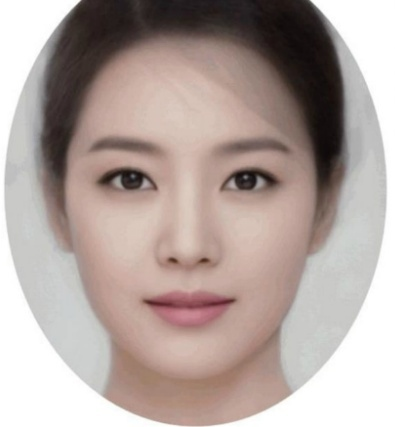

In [7]:
Image("/content/beauty.jpg")

In [8]:
import PIL.Image
def loader(image_name):
  image = PIL.Image.open(image_name)
  image= Variable(preprocessing(image))
  #fake batch dimension required to fit network's input dimensions
  image = image.unsqueeze(0)
  return image

In [10]:
#스타일과 콘텐츠 이미지를 로드
from PIL import Image
%pylab inline
style_image = loader("/content/beauty.jpg")
content_image = loader("/content/human.jpg")

Populating the interactive namespace from numpy and matplotlib


In [11]:
#콘텐츠 이미지를 생성
output_image = Variable(content_image.data.clone(), requires_grad = True)

In [12]:
vgg = vgg19(pretrained=True).features

Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth


  0%|          | 0.00/548M [00:00<?, ?B/s]

In [13]:
vgg = vgg19(pretrained=True).features

for param in vgg.parameters():
    param.requires_grad = False
if is_cuda:
    style_image = style_image.cuda()
    content_image = content_image.cuda()
    vgg = vgg.cuda()

In [14]:
output_image = Variable(content_image.data.clone(),requires_grad=True)

In [15]:
style_layers = [1,6,11,20,25]
content_layers = [21]
loss_layers = style_layers + content_layers

In [16]:
#채널마다 모든 값을 평탄화한 다음 이것의 전치 값과 곱하여 상관관계를 찾음
class GramMatrix(nn.Module):
  
  def forward(self, input):
    b,c,h,w = input.size()
    features = input.view(b,c,h*w)#flatten
    gram_matrix = torch.bmm(features, features.transpose(1,2))#전치와 곱함(bmm: 행렬 곱)
    gram_matrix.div_(h*w)#정규화
    return gram_matrix

In [17]:
gr = GramMatrix()
gr.forward(style_image)

tensor([[[7787.7163, 7275.7842, 7297.3159],
         [7275.7842, 6849.8174, 6860.9722],
         [7297.3159, 6860.9722, 7116.0894]]], device='cuda:0')

In [18]:
class StyleLoss(nn.Module):
  def forward(self, inputs, targets):
    out = nn.MSELoss()(GramMatrix()(inputs),targets)
    return (out)

In [19]:
class LayerActivations():
  features = []

  def __init__(self, model, layer_numbers):#layer_numbers: 출력을 추출한 레이어 번호
    self.hooks = []
    for layer_num in layer_numbers:
      self.hooks.append(model[layer_num].register_forward_hook(self.hook_fn))#register_forward_hook: VGG로부터 중간 레이어의 출력을 추출

  def hook_fn(self, module, input, output):
    self.features.append(output)#출력을 캡처하여 feartures 배열에 저장함

  def remove(self):#출력을 캡처하고 싶지 않으면
    for hook in self.hooks:
      hook.remove()
'''
  def extract_layers():#필요한 출력을 추출
    la = LayerActivations(model, layers)
    la.fearures = []#앞선 실행의 출력 포함하지 않도록 초기화
    out = model(images)
    la.remove()#모델에 등록된 모든 hook 제거
    return la.features()
    '''

'\n  def extract_layers():#필요한 출력을 추출\n    la = LayerActivations(model, layers)\n    la.fearures = []#앞선 실행의 출력 포함하지 않도록 초기화\n    out = model(images)\n    la.remove()#모델에 등록된 모든 hook 제거\n    return la.features()\n    '

In [20]:
style_layers = [1,6,11,20,25]
content_layers = [21]
loss_layers = style_layers + content_layers

In [21]:
def extract_layers(layers,img,model=None):
    la = LayerActivations(model,layers)
    #Clearing the cache 
    la.features = []
    out = model(img)
    la.remove()
    return la.features

In [22]:
#스타일 및 콘텐츠 이미지에 대해 필요한 target 추출하는 방법
content_targets = extract_layers(content_layers,content_image,model=vgg)
content_targets = [t.detach() for t in content_targets]#분리
style_targets = extract_layers(style_layers,style_image,model=vgg)
style_targets = [GramMatrix()(t).detach() for t in style_targets]#분리
targets = style_targets + content_targets#모든 target을 하나의 리스트로 합침

In [23]:
#these are good weights settings:
style_weights = [1e3/n**2 for n in [64,128,256,512,512]]
content_weights = [1e0]
weights = style_weights + content_weights

In [24]:
loss_fns = [StyleLoss()]*len(style_layers)+[nn.MSELoss()]*len(content_layers)

In [25]:
optimizer = optim.LBFGS([output_image])

In [26]:
maximum_iterations = 500#루프를 500번 반복
show_iteration = 50
n_iter = [0]
optimizer = optim.LBFGS([output_image]);
n_iteration = [0]

In [27]:
while n_iteration[0]<= maximum_iterations:
  def closure():
    optimizer.zero_grad()
    out = extract_layers(loss_layers, output_image, model = vgg)#메 반복마다 여러 레이어로부터 출력을 계산한다.
    #->output_image 변경됨
    #loss 계산
    layer_losses = [weights[a]*loss_fns[a](A,targets[a]) for a, A in enumerate(out)]
    loss = sum(layer_losses)
    loss.backward()
    n_iteration[0]+=1
    if n_iteration[0]%show_iteration == (show_iteration -1):
      print("Iteration: %d, loss: %f"%(n_iteration[0]+1, loss.data))
    return loss#손실 반환
  optimizer.step(closure)

Iteration: 50, loss: 359912.875000
Iteration: 100, loss: 97628.109375
Iteration: 150, loss: 30490.847656
Iteration: 200, loss: 14889.728516
Iteration: 250, loss: 10468.082031
Iteration: 300, loss: 9114.389648
Iteration: 350, loss: 8587.139648
Iteration: 400, loss: 8298.968750
Iteration: 450, loss: 8113.571289
Iteration: 500, loss: 7975.937500


# output

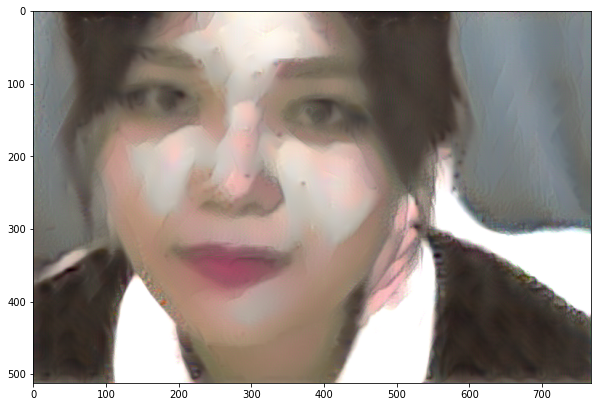

In [28]:
out_img_hr = postprocess_b(output_image.data[0].cpu().squeeze())

imshow(out_img_hr)
gcf().set_size_inches(10,10)

반복 추가

In [29]:
maximum_iterations = 2000#루프를 2000번 반복

In [30]:
while n_iteration[0]<= maximum_iterations:
  def closure():
    optimizer.zero_grad()
    out = extract_layers(loss_layers, output_image, model = vgg)#메 반복마다 여러 레이어로부터 출력을 계산한다.
    #->output_image 변경됨
    #loss 계산
    layer_losses = [weights[a]*loss_fns[a](A,targets[a]) for a, A in enumerate(out)]
    loss = sum(layer_losses)
    loss.backward()
    n_iteration[0]+=1
    if n_iteration[0]%show_iteration == (show_iteration -1):
      print("Iteration: %d, loss: %f"%(n_iteration[0]+1, loss.data))
    return loss#손실 반환
  optimizer.step(closure)

Iteration: 550, loss: 7866.060547
Iteration: 600, loss: 7777.839844
Iteration: 650, loss: 7702.527832
Iteration: 700, loss: 7638.103516
Iteration: 750, loss: 7583.037109
Iteration: 800, loss: 7534.125000
Iteration: 850, loss: 7490.904785
Iteration: 900, loss: 7452.621094
Iteration: 950, loss: 7418.641602
Iteration: 1000, loss: 7388.284180
Iteration: 1050, loss: 7360.434570
Iteration: 1100, loss: 7335.541992
Iteration: 1150, loss: 7312.669434
Iteration: 1200, loss: 7291.499023
Iteration: 1250, loss: 7271.841309
Iteration: 1300, loss: 7253.609375
Iteration: 1350, loss: 7236.981445
Iteration: 1400, loss: 7221.218750
Iteration: 1450, loss: 7206.476562
Iteration: 1500, loss: 7192.351562
Iteration: 1550, loss: 7179.296387
Iteration: 1600, loss: 7167.083008
Iteration: 1650, loss: 7155.213379
Iteration: 1700, loss: 7144.053223
Iteration: 1750, loss: 7133.489258
Iteration: 1800, loss: 7123.477051
Iteration: 1850, loss: 7113.963867
Iteration: 1900, loss: 7104.519531
Iteration: 1950, loss: 7095.0

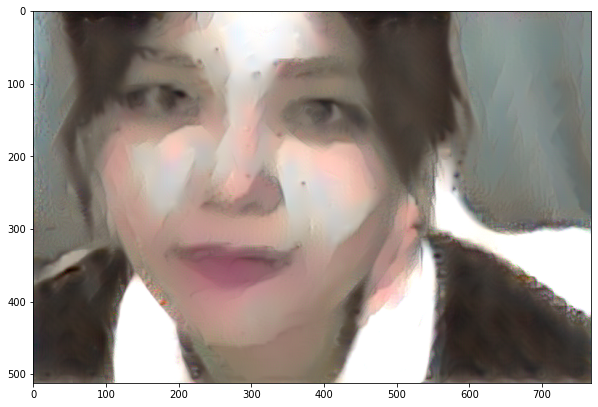

In [31]:
out_img_hr = postprocess_b(output_image.data[0].cpu().squeeze())

imshow(out_img_hr)
gcf().set_size_inches(10,10)